# Grid price impact
## Value iteration

In [70]:
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from numba import njit, prange

In [4]:
%config InlineBackend.figure_format = "retina"

## Problem setup
We consider the price process given by
$$
\begin{aligned}
    S_{t+\Delta} &= S_{t} + m_{t+\Delta}\Delta + \sigma\sqrt{\Delta}B(a_t),\\
    m_{t+\Delta} &= \kappa\,m_t + \sigma_m\sqrt{\Delta}B(p_m).
\end{aligned}
$$
The inventory process $Q_t$ and the cash process $X_t$ are given by
$$
\begin{aligned}
    Q_{t+\Delta} &= Q_t + a_t\\
    X_{t+\Delta} &= X_{t+\Delta} - a_t\,(S_t + \kappa a_t)
\end{aligned}
$$
with 
* $B(a_t) \sim \mathrm{Bern}(1 + \exp(-b\,a_t))$,
* $B(p_m) \sim \mathrm{Bern}(p_m)$,
* $p_m \in (0,1)$,
* $\kappa > 0$ a mean-reverting factor.
* $a_t\in \{a_\text{min}, a_\text{min} + 1, \ldots, a_\text{max} - 1, a_\text{max}\}$ action at time $t$.

The return at time $T$ is given by
$$
    G_T = X_T + Q_T\,S_T - \alpha\,Q_T^2.
$$
Then, the reward at time $t$ is given by
$$
    r_t = G_{t} - G_{t-1} =
    (Q_t + a_t)\, B(a_t) - (\kappa + \alpha)\,a^2_t - 2\,\alpha\,Q_t\,a_t + (Q_t + a_t)(\hat\kappa\,m_t + B(p_m)).
$$


To solve the problem in tabular form, we clip $S_t$ to a maximum and minimum value.

In [5]:
MAX_PRICE = 100 # price in [0, MAX_PRICE]
MAX_INVENTORY = 50 # max inventory per side
MAX_CASH = 50 # max cash per side
MAX_ACTION = 20 # max buy and sell
DISCOUNT = 0.9
MAX_SIGNAL = 10 # max value of signal per side

In [150]:
bins_signal = np.linspace(-3.5, 3.5, 60)

@njit
def clip(a, a_min, a_max):
    return np.minimum(a_max, np.maximum(a, a_min))


@njit
def sigmoid(z): return 1 / (1 + np.exp(-z))


@njit
def price_step(
    price, signal, action, sigma, sigma_signal, delta, price_impact, kappa_hat, force_signal
):
    # Signal step and discretise
    sign_signal = 2 * (np.random.uniform() < 0.5) - 1
    signal_next = signal * kappa_hat + sigma_signal * np.sqrt(delta) * sign_signal
    signal_next = bins_signal[np.digitize(np.array([signal_next]), bins_signal)].item()

    # price step and discretise
    pr = sigmoid(action * price_impact)
    sign = np.random.uniform() > (1 - pr)
    sign = 2 * sign - 1
    price_next = price + sigma * np.sqrt(delta) * sign + signal_next * delta * force_signal
    price_next = clip(price_next, 0.0, MAX_PRICE)
    
    return price_next, signal_next


@njit
def price_process(
    seed, price_init, actions,
    sigma=1.0, sigma_signal=1.0, delta=1.0, price_impact=1.0, kappa_hat=1.0,
    force_signal=1.0
):
    """
    Price process for a series of known actions
    """
    num_steps = len(actions)
    np.random.seed(seed)
    prices = np.zeros(num_steps)
    prices[0] = price_init

    signals = np.zeros(num_steps)
    signals[0] = 0.0

    
    for t in range(1, num_steps):
        price, signal = price_step(
            prices[t-1], signals[t-1], actions[t],
            sigma, sigma_signal, delta, price_impact, kappa_hat,
            force_signal,
        )
        prices[t] = price
        signals[t] = signal
    return prices, signals

## Example: deterministic actions

In [169]:
seed = 31415
num_steps = 300
price_init = 50
sigma_signal = 1.0
kappa_hat = 1 - 0.2
force_signal = 0.0

price_impacts = np.linspace(0, 1, 20)
colors = plt.cm.viridis(price_impacts)

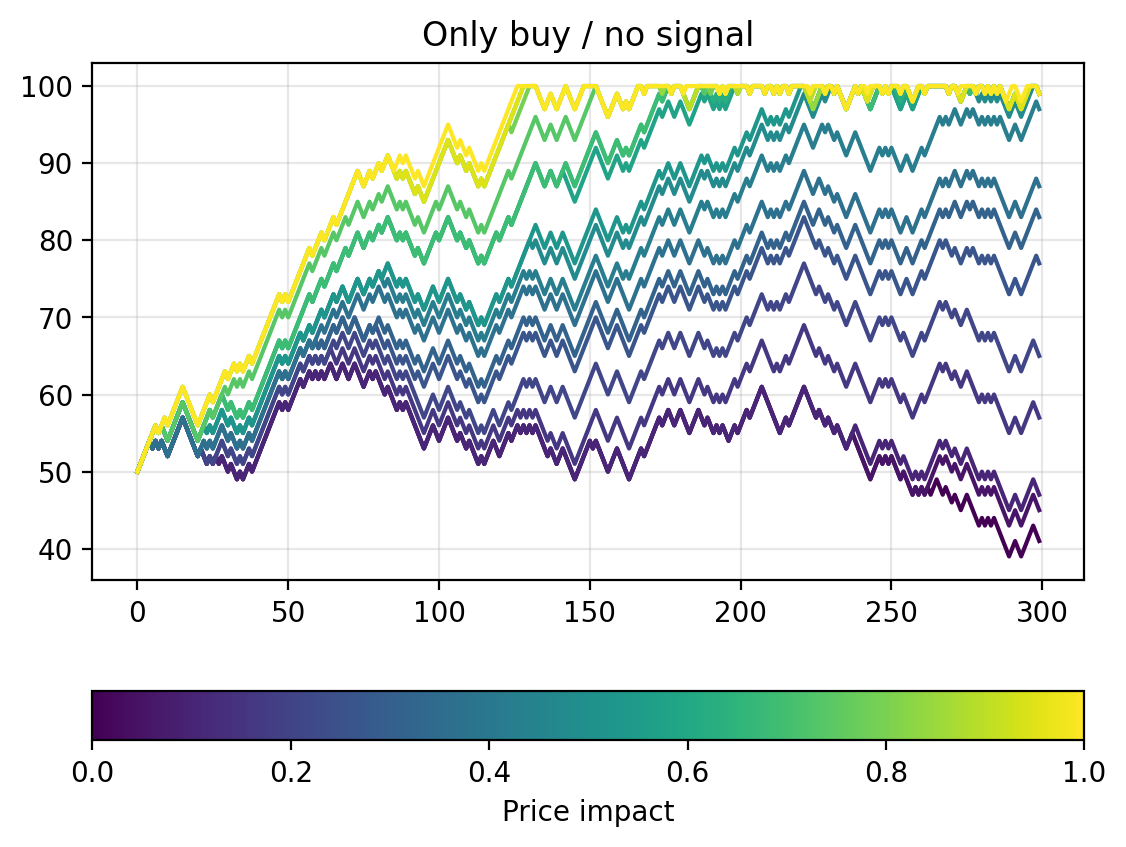

In [181]:
fig, ax = plt.subplots()

actions = np.ones(num_steps)
for color, price_impact in zip(colors, price_impacts):
    prices, signal = price_process(
        seed, price_init, actions,
        sigma_signal=sigma_signal,
        price_impact=price_impact,
        kappa_hat=kappa_hat,
        force_signal=force_signal,
        )
    ax.plot(prices, c=color)
    
ax.grid(alpha=0.3)
cnorm = mpl.colors.Normalize(0, 1)
mappable = mpl.cm.ScalarMappable(cnorm)
plt.title("Only buy / no signal")
fig.colorbar(mappable, ax=ax, orientation="horizontal", label="Price impact")

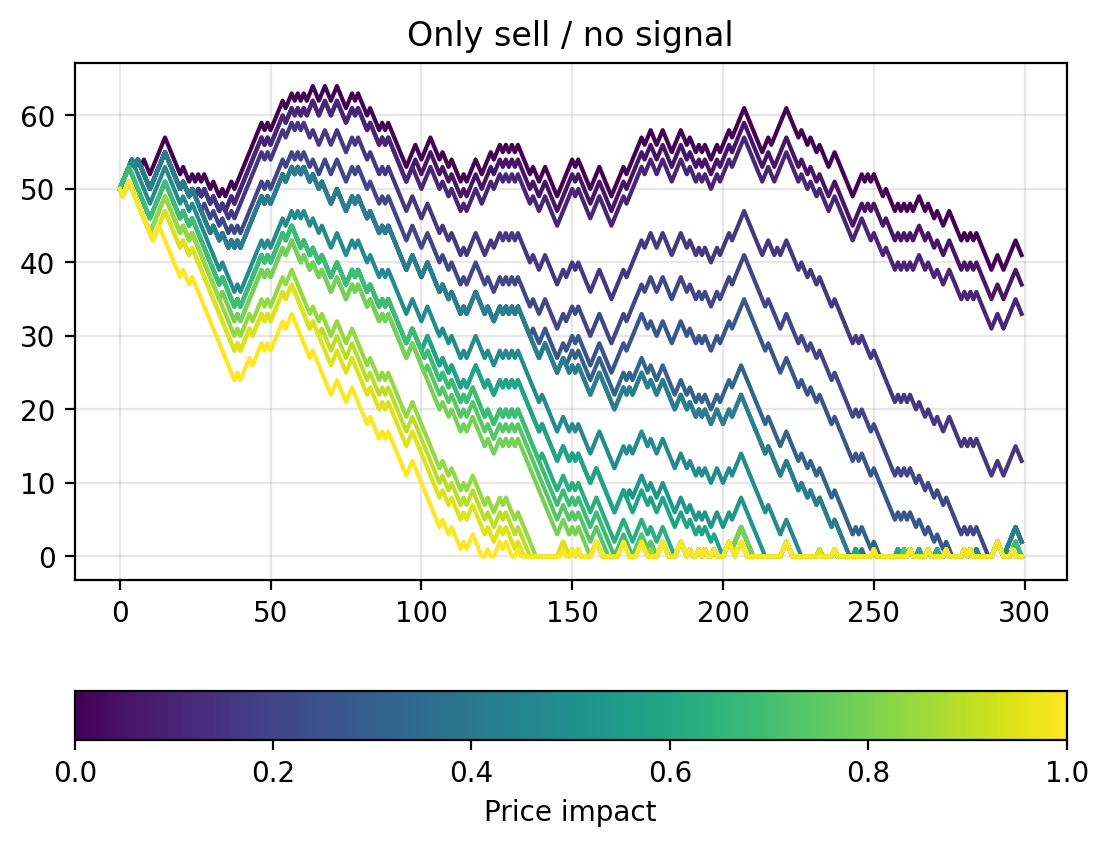

In [182]:
fig, ax = plt.subplots()

actions = -np.ones(num_steps)
for color, price_impact in zip(colors, price_impacts):
    prices, signal = price_process(
        seed, price_init, actions,
        sigma_signal=sigma_signal,
        price_impact=price_impact,
        kappa_hat=kappa_hat,
        force_signal=force_signal,
        )
    ax.plot(prices, c=color)
    
ax.grid(alpha=0.3)
cnorm = mpl.colors.Normalize(0, 1)
mappable = mpl.cm.ScalarMappable(cnorm)
plt.title("Only sell / no signal")
fig.colorbar(mappable, ax=ax, orientation="horizontal", label="Price impact")

## With signal

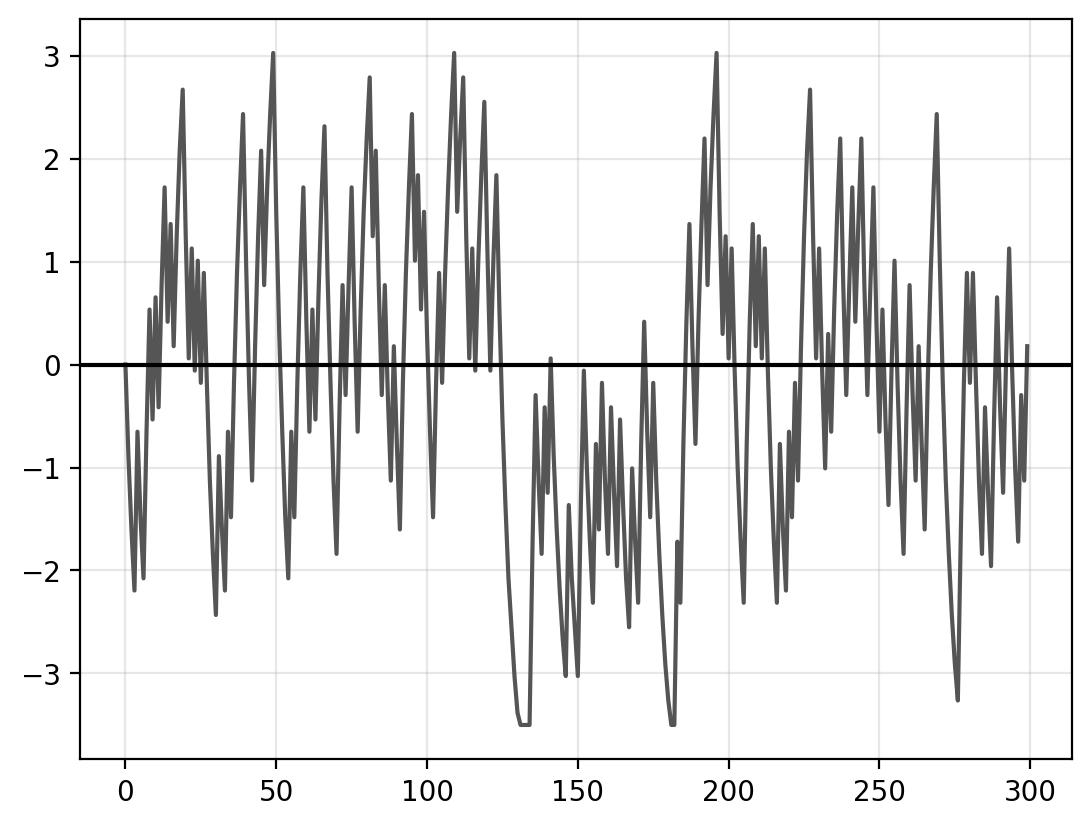

In [168]:
plt.plot(signal, c="#555555")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)

## Value iteration

Action-value function
$$
    q_\pi(s,\,a) = \sum_{s',\,r} p(s',\,r | s,\,a)[r + \gamma v(s')]
$$

## Bellman equation for the optimal value function

$$
    v_*(s) = \max_a\sum_{s',r} p(s',r | s, a)[r + \gamma v_*s('s)]
$$

In [8]:
@njit
def bern_pmf(y, mu):
    return mu ** y * (1 - mu) ** (1 - y)

@njit
def mdp(
    reward,
    signal_next, inventory_next,
    diff, signal, inventory, action,
    price_impact, temporary_price_impact, inventory_aversion
):
    """
    Markov decision process
    
    Parameters
    ----------
    diff: [-1, 1] — change in the price process
    """
    
    # Probability price transition
    # side = np.round(diff - signal_next + 1, 0) / 2
    side = np.round(diff + 1, 0) / 2
    
    
    p_impact = sigmoid(action * price_impact)
    pr_price = bern_pmf(side, p_impact) # either went up or down
    
    # Probability inventory transition
    pr_inventory = (inventory_next == inventory + action)
    
    
    # Probability signal transition
    diff_signal = signal_next -  kappa_hat * signal
    side_signal = np.round(diff_signal + 1, 0) / 2
    p_signal = 0.5 # Make optional parameter
    pr_signal = bern_pmf(side_signal, p_signal)
    
    
    # Probability reward
    pr_reward = (
        reward == (
            + (inventory + action) * diff
            - (temporary_price_impact + inventory_aversion) * action ** 2
            - 2 * inventory_aversion * action * inventory
            + (inventory + action) * signal_next
        )
    )
    
    pr = pr_signal * pr_price * pr_inventory * pr_reward
    return pr

## The action-value function

$$
    q_\pi(s, a) = \sum_{s',r}p(s', r | s, a)[r + \gamma v(s')]
$$

In [9]:
@njit
def state_to_position(signal, inventory):
    """
    Transform state values to indices
    in the value-function array
    """
    signal_ix = (signal + MAX_SIGNAL).astype(np.int32)
    inventory_ix = int(inventory + MAX_INVENTORY)
    
    return signal_ix, inventory_ix


@njit
def action_value_function(
    signal, inventory, action, value_function,
    price_impact, temporary_price_impact, inventory_aversion,
):
    
    action = float(action)
    price_changes = np.array([-1.0, +1.0])
    signals_new = kappa_hat * signal + np.array([-1.0, +1.0])
    signal_ix = np.digitize(signals_new, bins_signal)
    signals_new = bins_signal[signal_ix]
    
    inventory_new = inventory + action
    
    
    rewards = (
        + (inventory + action) * price_changes[None, :]
        - (temporary_price_impact + inventory_aversion) * action ** 2
        - 2 * inventory_aversion * action * inventory
        + (inventory + action) * signals_new[:, None]
    )
    

    # p(s', r | s, a)
    mdp_values = mdp(
        rewards, signals_new[:, None], inventory_new, price_changes[None, :],
        signal, inventory, action,
        price_impact, temporary_price_impact, inventory_aversion
    )
    
    inventory_new = clip(inventory_new, -MAX_INVENTORY, MAX_INVENTORY)
    
    _, inventory_ix = state_to_position(signals_new, inventory_new)
    values = value_function[signal_ix, inventory_ix]
    
    mdp_values = mdp_values / mdp_values.sum() # renormalise
    value_est = mdp_values * (rewards + DISCOUNT * values[:, None])
    
    return value_est.sum()

In [10]:
values_signals = bins_signal.copy()
values_inventory = np.arange(-MAX_INVENTORY, MAX_INVENTORY + 1)
actions = np.arange(-MAX_ACTION, MAX_ACTION + 1)

In [11]:
value_function = np.zeros((
    len(bins_signal),
    2 * MAX_INVENTORY + 1,
))


action_value_function(
    signal=0.0,
    inventory=1.0,
    action=-10,
    value_function=value_function,
    price_impact=0.1,
    temporary_price_impact=1.0,
    inventory_aversion=0.0
)

-96.37484388974465

## Bellman equation for the optimal value function

$$
    v_*(s) = \max_a\sum_{s',r} p(s',r | s, a)[r + \gamma v_*s('s)]
$$

In [12]:
@njit
def value_iteration_state(
    signal, inventory, actions, value_function,
    price_impact, temporary_price_impact, inventory_aversion,
):
    """
    Value iteration for a single given state
    """
    v_max = -np.inf
    action_max = np.nan
    
    for action in actions:
        value = action_value_function(
            signal, inventory, action, value_function,
            price_impact, temporary_price_impact, inventory_aversion
        )
        
        if value > v_max:
            v_max = value
            action_max = action
    
    return v_max, action_max

In [13]:
@njit(parallel=True)
def value_iteration_single(
    signal_arr, inventory_arr, actions, value_function,
    price_impact, temporary_price_impact, inventory_aversion
):
    value_function_update = np.zeros_like(value_function, dtype=np.float64)
    actions_update = np.zeros_like(value_function, dtype=np.int32)
    
    for s_ix in prange(signal_arr.shape[0]):
        for i_ix in prange(inventory_arr.shape[0]):
            signal = signal_arr[s_ix]
            inventory = inventory_arr[i_ix]

            val, action = value_iteration_state(
                signal, inventory, actions, value_function,
                price_impact, temporary_price_impact, inventory_aversion,
            )

            value_function_update[s_ix, i_ix] = val
            actions_update[s_ix, i_ix] = action
    
    return value_function_update, actions_update

In [14]:
@njit
def value_iteration(
    signal_arr, inventory_arr, actions, value_function_init,
    price_impact, temporary_price_impact, inventory_aversion,
    err_max, max_it=50,
):
    
    value_function = value_function_init.copy()
    errs_hist = []
    for i in range(max_it):
        value_function_new, action_function = value_iteration_single(
            signal_arr=signal_arr,
            inventory_arr=inventory_arr,
            actions=actions,
            value_function=value_function,
            price_impact=price_impact,
            temporary_price_impact=temporary_price_impact,
            inventory_aversion=inventory_aversion
        )
        errs = np.abs(value_function - value_function_new)
        value_function = value_function_new
        errs_hist.append(errs.max())
        if errs.max() <= err_max:
            break
    
    return value_function, action_function, np.array(errs_hist)

In [15]:
%%time
value_function = np.zeros((
    len(bins_signal),
    2 * MAX_INVENTORY + 1,
))

price_impact = 0.1 # 1.0
temporary_price_impact = 1.0
inventory_aversion = 0.1

value_function, action_function, errs_hist = value_iteration(
    signal_arr=values_signals,
    inventory_arr=values_inventory,
    actions=actions,
    value_function_init=value_function,
    price_impact=price_impact,
    temporary_price_impact=temporary_price_impact, # 0.0
    inventory_aversion=inventory_aversion,
    err_max=0.2,
    max_it=50
);

CPU times: user 40.5 s, sys: 266 ms, total: 40.8 s
Wall time: 16.3 s


Text(0.5, 1.0, '$\\Delta$ value function')

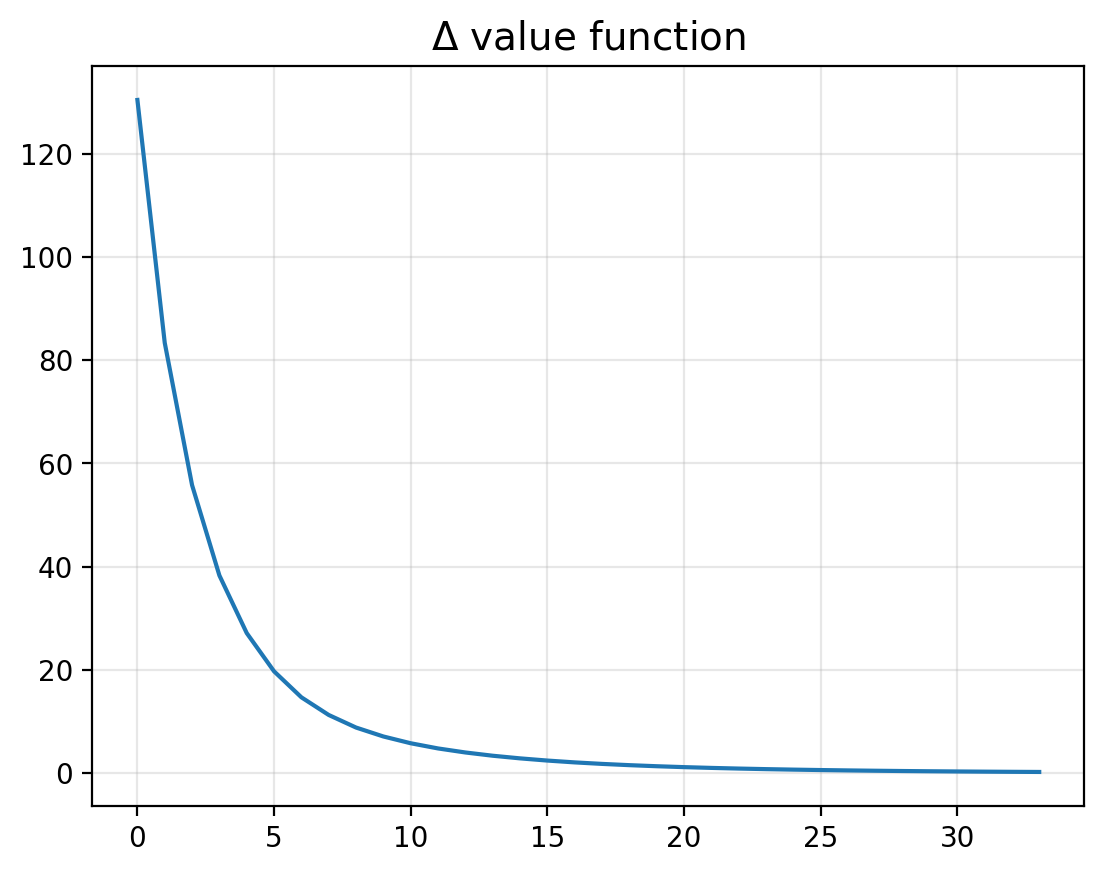

In [16]:
plt.plot(errs_hist)
plt.grid(alpha=0.3)
plt.title("$\Delta$ value function", fontsize=14)

Text(50.7222222222222, 0.5, 'Signal')

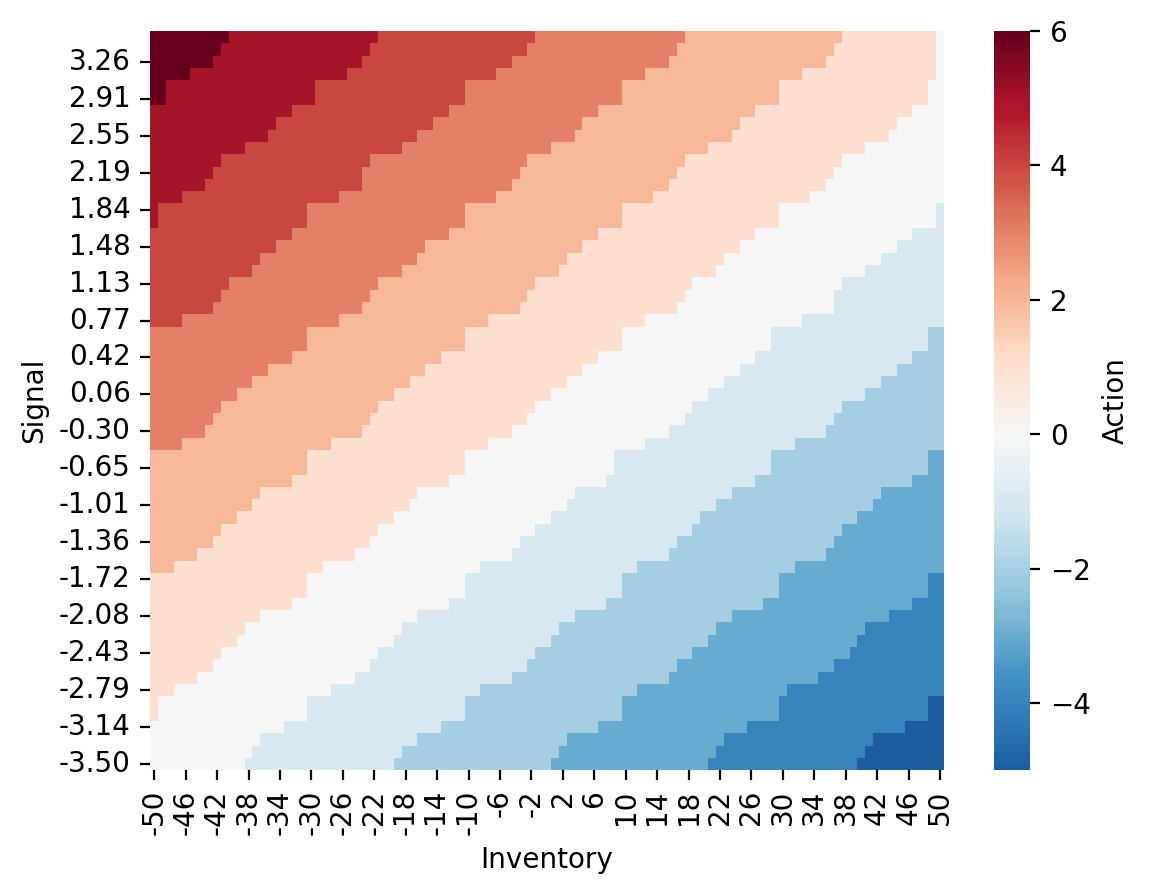

In [17]:
action_function_df = pd.DataFrame(
    action_function, index=values_signals, columns=values_inventory
)
ax = sns.heatmap(
    action_function_df, cmap="RdBu_r", center=0, cbar_kws={"label":"Action"},
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])

plt.gca().invert_yaxis()
plt.xlabel("Inventory")
plt.ylabel("Signal")

Text(50.7222222222222, 0.5, 'Signal')

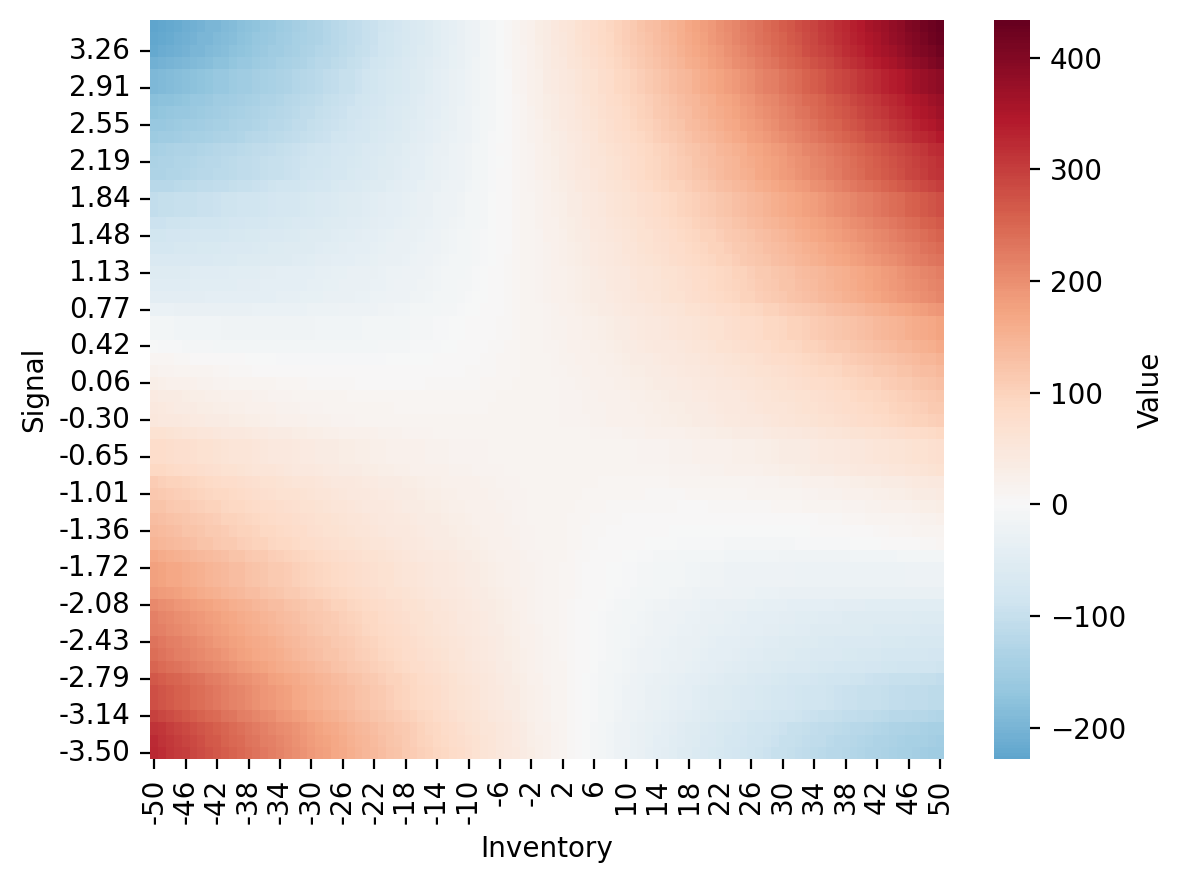

In [18]:
value_function_df = pd.DataFrame(value_function, index=values_signals, columns=values_inventory)
ax = sns.heatmap(
    value_function_df, cmap="RdBu_r", center=0.0, cbar_kws={"label": "Value"}
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])

plt.gca().invert_yaxis()
plt.xlabel("Inventory")
plt.ylabel("Signal")

Text(50.7222222222222, 0.5, 'Signal')

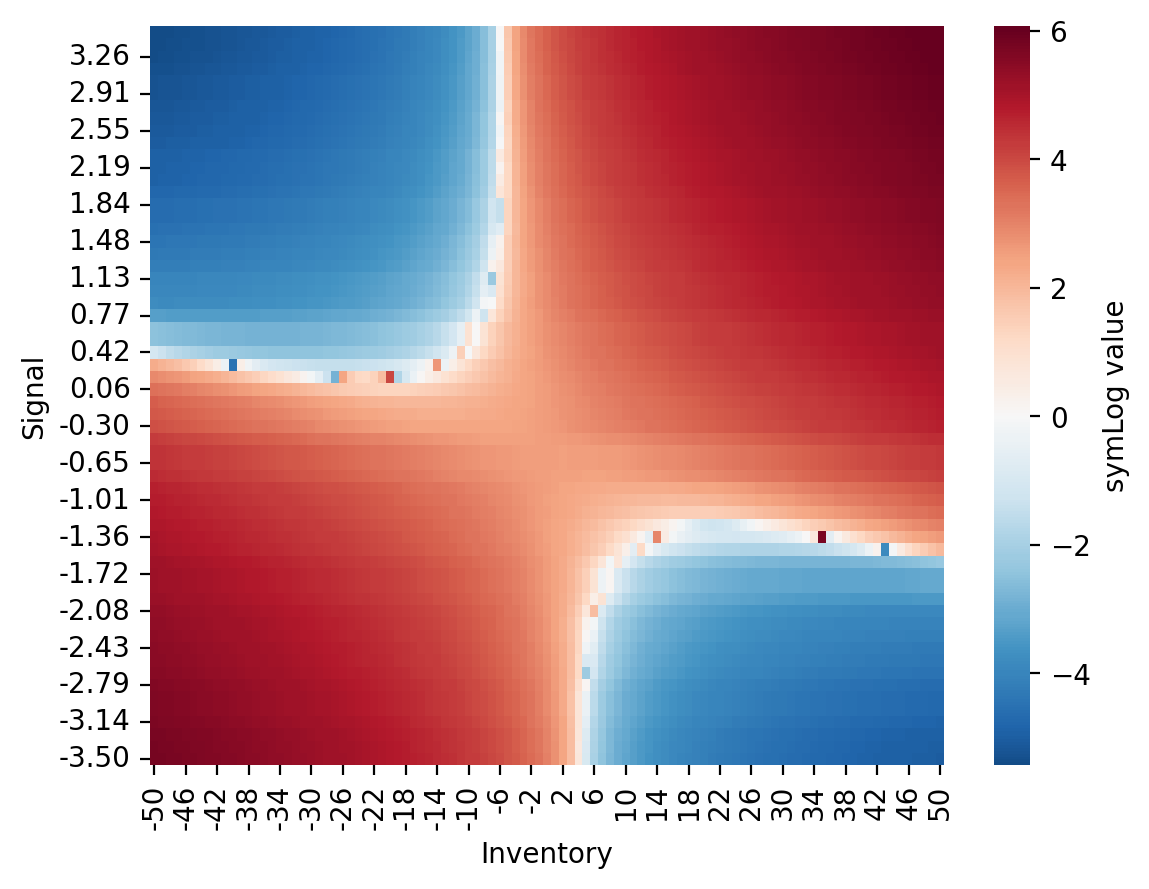

In [19]:
log_value_function = np.sign(value_function) * np.log(np.abs(value_function))
log_value_function_df = pd.DataFrame(log_value_function, index=values_signals, columns=values_inventory)

ax = sns.heatmap(
    log_value_function_df, cmap="RdBu_r", center=0.0, cbar_kws={"label": "symLog value"}
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])
plt.gca().invert_yaxis()
plt.xlabel("Inventory")
plt.ylabel("Signal")

## Run a simulation

In [20]:
def price_step(price, signal, action, sigma, sigma_signal, delta, price_impact, kappa_hat):
    sign_signal = 2 * (np.random.uniform() < 0.5) - 1
    signal_next = (
        signal * kappa_hat + sigma_signal * np.sqrt(delta) * sign_signal
    )
    signal_next = bins_signal[np.digitize(signal_next, bins_signal)]
    
    pr = sigmoid(action * price_impact)
    sign = np.random.uniform() > 1 - pr
    sign = 2 * sign - 1
        
    price_next = price + sigma * np.sqrt(delta) * sign + signal_next * delta
    # price_next = np.maximum(0.0, price_next) # Minimum price is 0.0
    price_next = clip(price_next, 0.0, MAX_PRICE)
    return price_next, signal_next


In [21]:
signal = 0.0
price = 10
inventory = 0
cash = 0
sigma = sigma_signal = delta = 1.0

steps = 3000
price_hist = np.zeros(steps)
action_hist = np.zeros(steps)
reward_hist = np.zeros(steps)
inventory_hist = np.zeros(steps)
cash_hist = np.zeros(steps)
signal_hist = np.zeros(steps)

np.random.seed(314159)
for t in range(steps):
    signal_ix = np.digitize(signal, bins_signal)
    _, inventory_ix = state_to_position(np.array([signal]), inventory)
    action = action_function[signal_ix, inventory_ix].item()
    
    
    cash = cash - action * (price + temporary_price_impact * action)
    price_new, signal = price_step(
        price, signal, action, sigma=sigma, sigma_signal=sigma_signal,
        delta=delta, price_impact=price_impact, kappa_hat=kappa_hat,
    )
    price_change, price = price_new - price, price_new
    inventory = inventory + action
    
    reward = (
        + inventory * price_change
        - (temporary_price_impact + inventory_aversion) * action ** 2
        - 2 * inventory_aversion * action * (inventory - action)
        
    )
    
    price = clip(price, 0.0, MAX_PRICE)
    inventory = clip(inventory, -MAX_INVENTORY, MAX_INVENTORY)
    cash = clip(cash, -MAX_CASH, MAX_CASH)
    
    signal_hist[t] = signal
    price_hist[t] = price
    action_hist[t] = action
    reward_hist[t] = reward
    inventory_hist[t] = inventory
    cash_hist[t] = cash

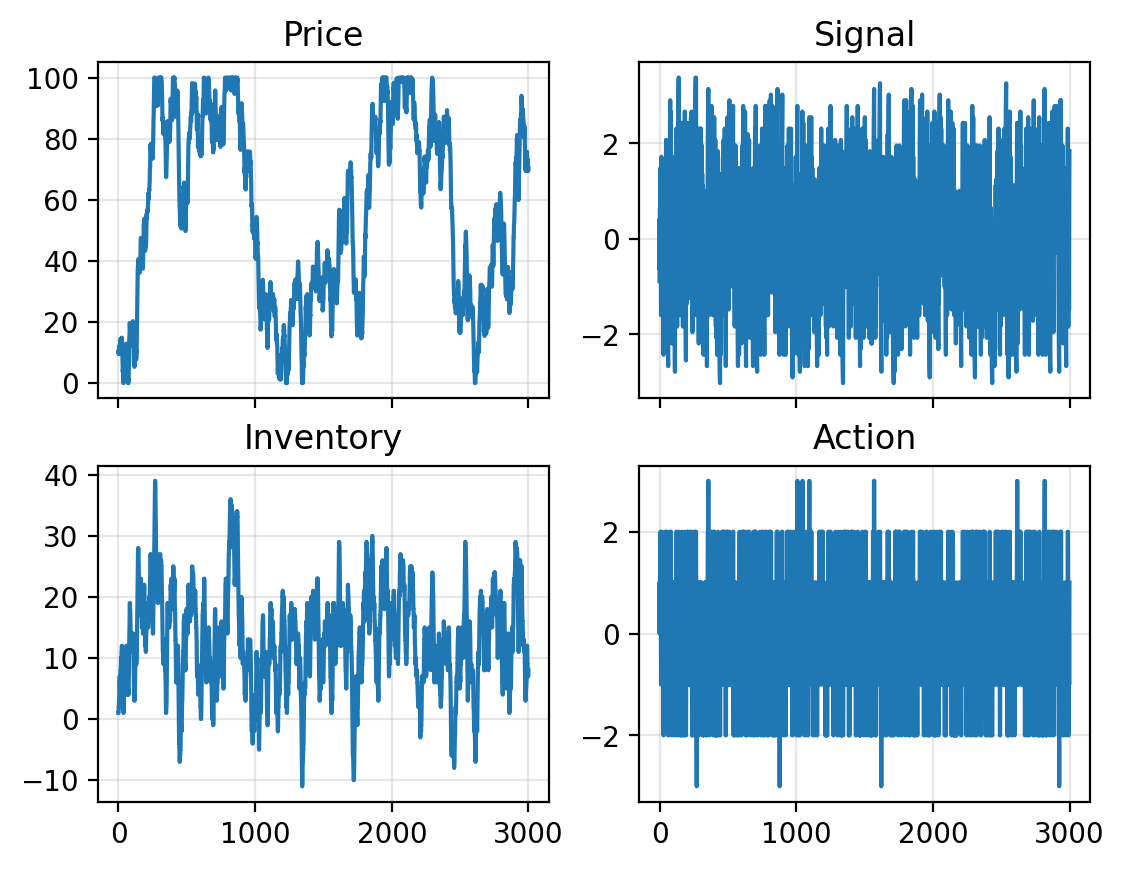

In [22]:
fig, axs = plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

axs[0].plot(price_hist)
axs[1].plot(signal_hist)
axs[2].plot(inventory_hist)
axs[3].plot(action_hist)

labels = ["Price", "Signal", "Inventory", "Action"]
for ax, label in zip(axs, labels):
    ax.grid(alpha=0.3)
    ax.set_title(label)

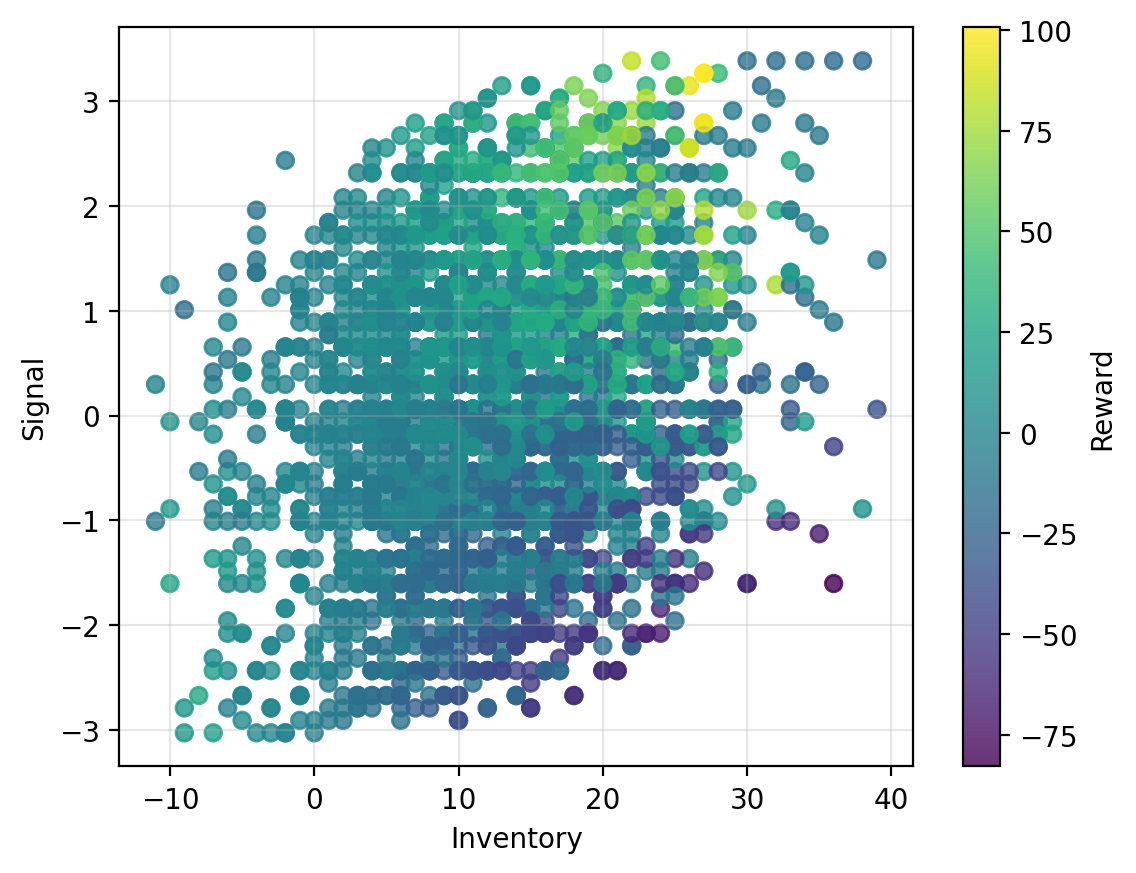

In [23]:
plt.scatter(inventory_hist, signal_hist, c=reward_hist, alpha=0.8, cmap="viridis")
plt.grid(alpha=0.3)
plt.xlabel("Inventory")
plt.ylabel("Signal")
plt.colorbar(label="Reward")

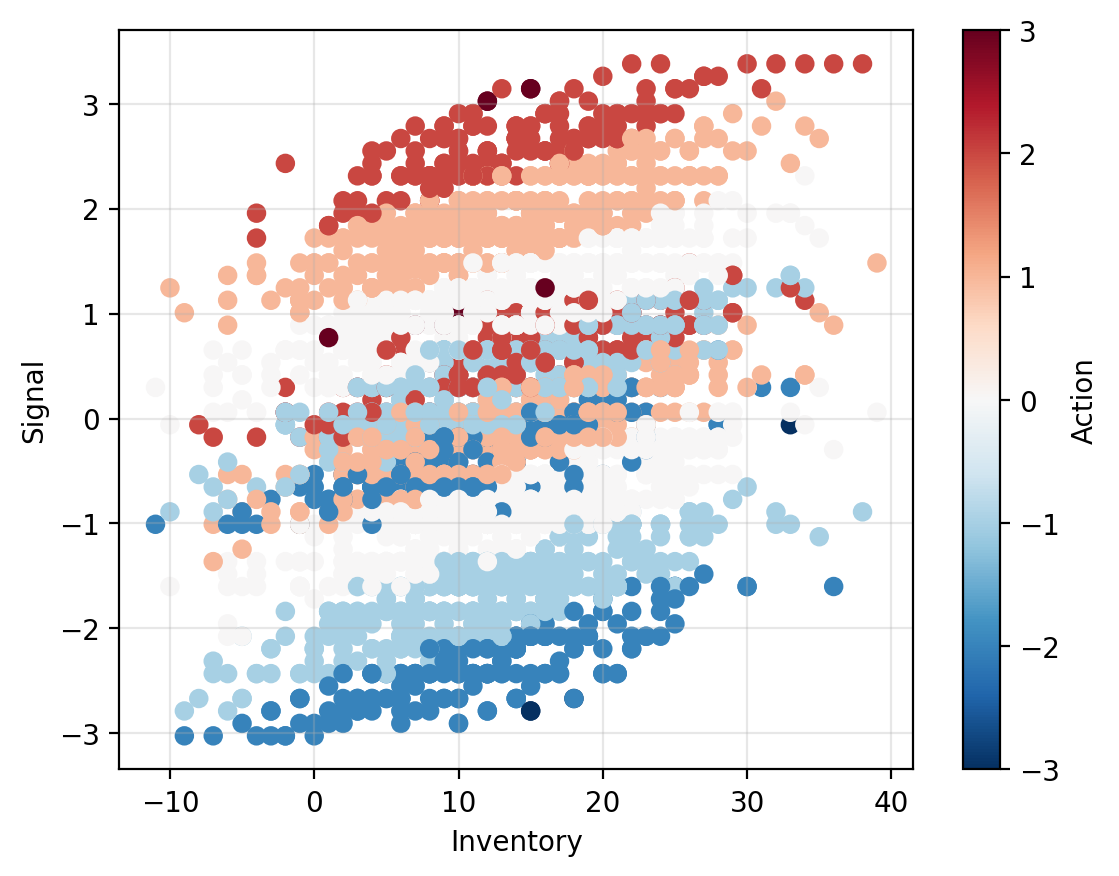

In [24]:
plt.scatter(inventory_hist, signal_hist, c=action_hist, cmap="RdBu_r")
plt.grid(alpha=0.3)
plt.xlabel("Inventory")
plt.ylabel("Signal")
plt.colorbar(label="Action")

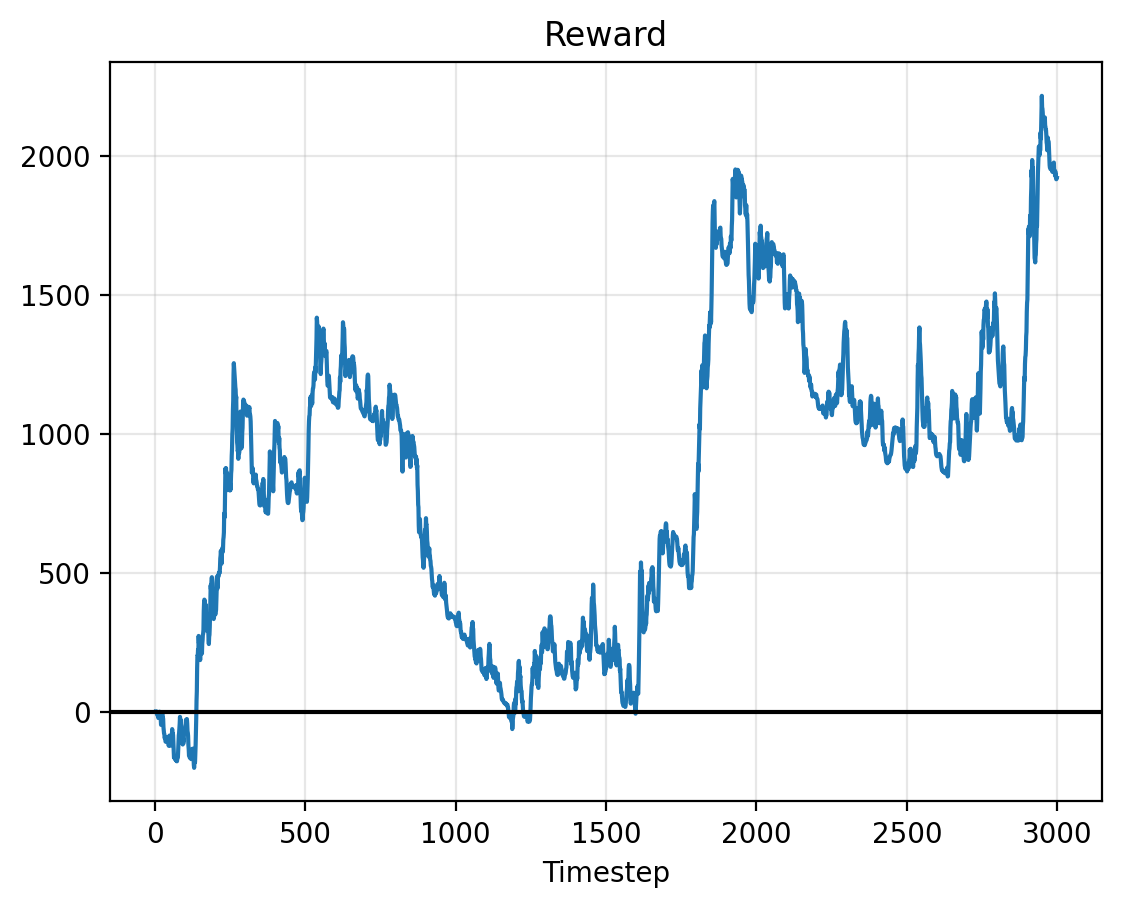

In [25]:
plt.plot(reward_hist.cumsum())
plt.title("Reward")
plt.xlabel("Timestep")
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)